# Session 1 : Training your first aircraft detector with pytorch

**Intro**

The objectives of this session is to apply what you learned during [the previous class on Deep Learning](https://github.com/erachelson/MLclass/blob/master/7%20-%20Deep%20Learning/Deep%20Learning.ipynb) on a real dataset of satellite images.

Most of the vocabulary and concepts of Deep Learning and Convolutionnal Neural Network has been defined on the notebook linked above so you should refer to it.

The objective of the first session is to apply what was detailed above on another dataset using higher level tools such as [skorch](https://github.com/skorch-dev/skorch).

In this session you will:
- Get a preview of using skorch
- Train a basic NN on a basic dataset
- Plot ROC curve & confusion matrix to diagnose your dataset

During session 2 you will be experimenting with harder datasets

In [1]:
# install dependencies
%pip install skorch

     |████████████████████████████████| 112kB 6.3MB/s 


In [0]:
# Put your imports here
import numpy as np

In [0]:
# Configuration variables
TOY_DATASET_URL = "https://storage.googleapis.com/isae-deep-learning/toy_aircraft_dataset.npz"

## Downloading the dataset

We will be using [numpy datasources](https://docs.scipy.org/doc/numpy/reference/generated/numpy.DataSource.html?highlight=datasources) to download the dataset. DataSources can be local files or remote files/URLs. The files may also be compressed or uncompressed. DataSource hides some of the low-level details of downloading the file, allowing you to simply pass in a valid file path (or URL) and obtain a file object.

The dataset is in npz format which is a packaging format where we store several numpy arrays in key-value format

Note:
If you get an error with the code below run:
```python
!gsutil -m cp -r gs://isae-deep-learning/toy_aircraft_dataset.npz /tmp/storage.googleapis.com/isae-deep-learning/toy_aircraft_dataset.npz
```
in a cell above the cell below

In [0]:
ds = np.DataSource(destpath="/tmp/")
f = ds.open(TOY_DATASET_URL, 'rb')

toy_dataset = np.load(f)
train_images = toy_dataset['train_images']
train_labels = toy_dataset['train_labels']
test_images = toy_dataset['test_images']
test_labels = toy_dataset['test_labels']

In [7]:
toy_dataset

### A bit about train-test 

You just downloaded a training and a test set.
skorch will automatically split your training dataset into training and validation.
- We use the training set for forward/backward 
- We use the validation set to tune hyperparameters (optimizers, early stopping)
- We use the test set for final metrics on our tuned model

![](https://i.stack.imgur.com/osBuF.png)

For more information as to why we use train/validation and test refer to this article:
https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

## A bit of data exploration

Q1. Labels counting
a. What is the dataset size ?

b. How many images representing aircrafts ?

c. How many images representing backgrounds ?

d. What are the dimensions (height and width) of the images ? What are the number of channels ?

In [14]:
len(train_images), sum(train_labels), (train_images).shape

(2250, 1125, (2250, 64, 64, 3))

Q2. Can you plot at least 8 examples of each label ? In a 4x4 grid ?

Here are some functionnality examples. Try them and make your own. A well-understandood dataset is the key to an efficient model.

In [0]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
LABEL_NAMES = ["Not an aircraft", "Aircraft"]

print("Labels counts :")

for c, l, label in zip(*np.unique(train_labels, return_counts=True), LABEL_NAMES):
    print(f" Label: {label} , value: {l}, count: {c}")

Labels counts :
 Label: Not an aircraft , value: 1125, count: 0
 Label: Aircraft , value: 1125, count: 1


In [17]:
for l, label in enumerate(LABEL_NAMES):
    print(f"Examples shape for label {l} : {train_images[train_labels == l, ::].shape}")

Examples shape for label 0 : (1125, 64, 64, 3)
Examples shape for label 1 : (1125, 64, 64, 3)


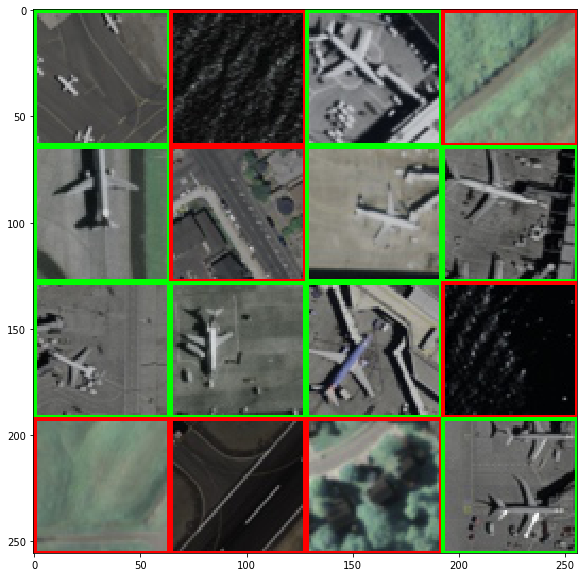

In [18]:
grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        tile = np.copy(train_images[i * grid_size + j])
        label = np.copy(train_labels[i * grid_size + j])
        color = (0, 255, 0) if label == 1 else (255, 0, 0)
        tile = cv2.rectangle(tile, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

# Training

In order to simplify the code, we will use the [skorch](https://github.com/skorch-dev/skorch) library. It provides a convenient wrapper and avoid the need of re writing the training loop eah time:

```python
for epoch in range(10):
    for batch in batches:
        # torch forward
        # torch backward
```

If you still prefer writing your own loop, feel free to overwrite the next cells.

If you need any help with functionalities of skorch, you [can find here](https://nbviewer.jupyter.org/github/skorch-dev/skorch/tree/master/notebooks/) the reference notebooks of the library

In [0]:
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
# Define the torch model to use
# Here a sequential layer is used instead of the classical nn.Module
# If you need to write your own module, plenty of resources are available one the web or in deep learning course
module = nn.Sequential(
    nn.Conv2d(3, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(6 * 6 * 64, 256),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 2),
    nn.Softmax(),
)

In [0]:
# The famous skorch wrapper useful yet not complex and it has a sklearn friendly API

net = NeuralNetClassifier(
    module,
    max_epochs=10,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer=optim.SGD)

In [22]:
train_images.transpose((0, 3, 1, 2))

array([[[[ 80,  76,  75, ...,  81,  82,  86],
         [ 76,  73,  88, ...,  89,  89,  97],
         [ 76,  78, 108, ...,  92,  91, 102],
         ...,
         [116, 152, 142, ...,  94,  95,  95],
         [135, 160, 137, ...,  97,  96, 100],
         [156, 147, 172, ...,  98, 101, 101]],

        [[ 79,  75,  74, ...,  80,  81,  85],
         [ 75,  72,  87, ...,  88,  88,  96],
         [ 75,  77, 107, ...,  91,  90, 101],
         ...,
         [116, 152, 142, ...,  89,  88,  88],
         [135, 160, 137, ...,  90,  89,  93],
         [156, 147, 172, ...,  91,  94,  94]],

        [[ 75,  71,  70, ...,  75,  76,  80],
         [ 71,  68,  83, ...,  83,  83,  91],
         [ 71,  73, 103, ...,  86,  85,  96],
         ...,
         [116, 152, 142, ...,  83,  82,  82],
         [137, 162, 137, ...,  84,  81,  85],
         [158, 149, 172, ...,  83,  86,  84]]],


       [[[ 23,  40,  29, ...,  32,  39,  27],
         [ 27,  40,  27, ...,  40,  23,  14],
         [ 19,  15,  14, ..., 

In [23]:
# The training loop
# Each epoch should take at most 1 second since we are executing the network on a GPU

net.fit(train_images.transpose((0, 3, 1, 2)).astype(np.float32), train_labels)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5627       0.7533        0.5343  1.1196
      2        0.4358       0.8489        0.4139  0.9278
      3        0.3657       0.7400        0.4624  0.9327
      4        0.3318       0.8933        0.3090  0.9266
      5        0.2882       0.5289        1.0426  0.9251
      6        0.2737       0.9133        0.2622  0.9336
      7        0.2398       0.7000        0.5627  0.9343
      8        0.2247       0.9178        0.2318  0.9334
      9        0.2101       0.9111        0.2201  0.9293
     10        0.1865       0.8533        0.3396  0.9323


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=2304, out_features=256, bias=True)
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16

# Testing and metrics

Now that we have a trained network, it is important to measure how well it performs.

You can refer to your ML course or on resources on the web to see how we can measure it.


## Confusion matrix
Here, we are first computing the [confusion matrix]():

In [24]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix")
confusion_matrix(train_labels, net.predict(train_images.transpose((0, 3, 1, 2)).astype(np.float32)))

Confusion matrix


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


array([[1100,   25],
       [ 282,  843]])

In [27]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix")
confusion_matrix(test_labels, net.predict(test_images.transpose((0, 3, 1, 2)).astype(np.float32)))

Confusion matrix


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


array([[352,  23],
       [194, 181]])

## ROC curve

The next metric we are computing is the [ROC curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

It used to choose a threshold on the output probability in case you are intesrested in controling the false positive rate.

In [57]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class

fpr, tpr, t = roc_curve(test_labels, net.predict_proba(test_images.transpose((0, 3, 1, 2)).astype(np.float32))[:, 1])
roc_auc = auc(fpr, tpr)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


No handles with labels found to put in legend.


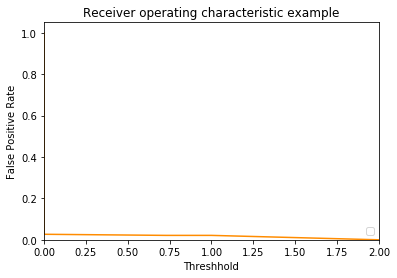

In [64]:
plt.figure()
lw = 2
plt.plot(t, fpr, color='darkorange')

plt.xlim([0.0, 2.0])
plt.ylim([0.0, 1.05])
plt.ylabel('False Positive Rate')
plt.xlabel('Threshhold')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [65]:

t,fpr, tpr

(array([2.0000000e+00, 1.0000000e+00, 7.2825110e-01, 5.6950472e-07,
        3.0603764e-15, 7.7350491e-21, 3.3597703e-29, 1.0662537e-31,
        4.1740399e-34, 9.3746867e-43, 1.1490647e-43, 0.0000000e+00],
       dtype=float32),
 array([0.        , 0.02133333, 0.02133333, 0.02666667, 0.02666667,
        0.032     , 0.032     , 0.03466667, 0.03466667, 0.04533333,
        0.04533333, 1.        ]),
 array([0.        , 0.26933333, 0.27733333, 0.27733333, 0.29333333,
        0.29333333, 0.29866667, 0.29866667, 0.304     , 0.304     ,
        0.30666667, 1.        ]))

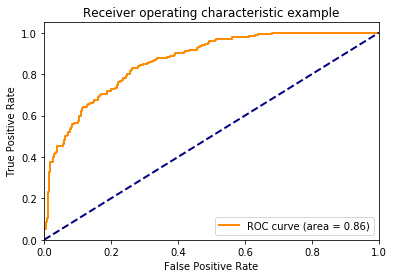

In [26]:
cplt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Misclassified examples

It is always interesting to check mis classified examples.

It usually provides tips on how to improve your model.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


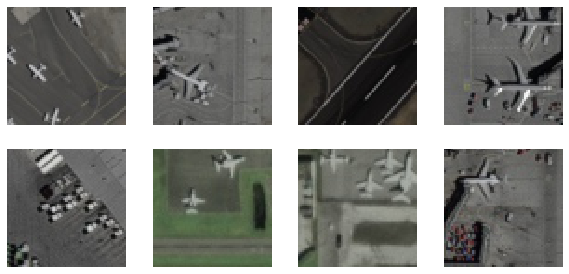

In [28]:
from itertools import islice

misclassified_examples = train_images[net.predict(train_images.transpose(
    (0, 3, 1, 2)).astype(np.float32)) != train_labels, ::]

plt.figure(figsize=(10, 10))
for idx, im in enumerate(islice(misclassified_examples, 0, 8)):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(im)
    plt.axis("off")

# Using more advanced features with skorch

We will either edit the loop above or write a new fit loop to use advanced features of skorch

## Adding callbacks

Last time we saw "callbacks" such as early stopping. Try to integrate them to the fit loop above.

Here are references on "callbacks" with skorch:

https://nbviewer.jupyter.org/github/skorch-dev/skorch/blob/master/notebooks/Basic_Usage.ipynb

https://skorch.readthedocs.io/en/stable/callbacks.html#skorch.callbacks.EarlyStopping

```python

from skorch.callbacks import EarlyStopping

early_stopping = EarlyStopping(scoring='roc_auc', lower_is_better=False)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    callbacks=[early_stopping],
)
```

In [36]:
# Use callbacks
from skorch.callbacks import EarlyStopping
 
early_stopping = EarlyStopping(monitor='valid_loss', lower_is_better=True)

net = NeuralNetClassifier(
    module,
    max_epochs=10,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks=[early_stopping],
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer=optim.SGD)
net.fit(train_images.transpose((0, 3, 1, 2)).astype(np.float32), train_labels)



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2278       0.7467        0.6914  1.0479
      2        0.1942       0.5933        1.3535  0.9414
      3        0.1851       0.5000        4.0309  0.9438
      4        0.2264       0.9311        0.2008  0.9502
      5        0.1350       0.8378        0.5476  0.9424
      6        0.1287       0.9400        0.2268  0.9478
      7        0.1143       0.6244        1.1705  0.9433
      8        0.1146       0.8644        0.3481  0.9426
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=2304, out_features=256, bias=True)
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16

## [OPTIONAL] Data Augmentation


One technique for training CNNs on images is to put your training data through data augmentation to generate similar-but-different examples to make your network more robust.

You can generate "augmented images" on the fly or use composition to generate data

- We are going to wrap our numpy arrays with `torch.utils.data.Dataset` class 

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

- Here is how we deal with torch.data.Dataset formats with skorch: 

https://nbviewer.jupyter.org/github/skorch-dev/skorch/blob/master/notebooks/Advanced_Usage.ipynb#Working-with-Datasets

- Here is how we use torch Compose to augment data

https://pytorch.org/docs/stable/torchvision/transforms.html

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms

Note: This step requires a bit of tinkering from numpy arrays to torch datasets, it's fine if you skip it. For the next notebook it may prove a useful way of gaining performance

In [0]:
# Add data augmentation
import torch.functional
import torch.utils
import torchvision

In [0]:
class DatasetFromNumpy(torch.utils.data.Dataset):
    def __init__(self, array_x, array_y, transform=None):
        self.array_x = array_x
        self.array_y = array_y
        self.transform = transform

    def __len__(self):
        return self.array_x.shape[0]

    def __getitem__(self, idx):
        x = self.array_x[idx]
        y = self.array_y[idx]
        if self.transform is not None:
            x = self.transform(x)
        else:
            x = torch.tensor(x)
        y = torch.tensor(y)
        return x, y

In [0]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
])

In [0]:
train_ds = DatasetFromNumpy(array_x=train_images, array_y=train_labels, transform=train_transform)

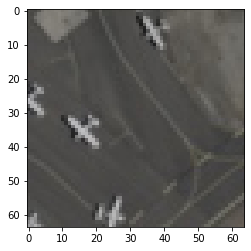

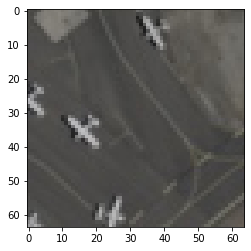

In [43]:
# Compare effects of data augmentation
img_orig = train_images[0]
plt.imshow(img_orig)
plt.show()
# Get image from dataset. Note: it has been converted as a torch tensor in CHW format in float32 normalized !
img, label = train_ds[0]
img = (img.numpy() * 255.).astype(np.uint8)
img = np.rollaxis(img, 0,3)
plt.imshow(img)
plt.show()

In [44]:
# we need to pass train_labels back for train-validation split !
# https://nbviewer.jupyter.org/github/skorch-dev/skorch/blob/master/notebooks/Advanced_Usage.ipynb#Working-with-Datasets
net.fit(train_ds, y=train_labels)

Re-initializing optimizer.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3221       0.5000        0.9026  1.3907
      2        0.1428       0.5000        0.9288  1.2971
      3        0.1317       0.5000        0.9498  1.2852
      4        0.1906       0.5000        0.7615  1.3270
      5        0.1732       0.5444        0.6210  1.2918
      6        0.1127       0.7444        0.4781  1.3040
      7        0.1088       0.6578        1.0165  1.3072
      8        0.1791       0.9111        0.2422  1.2930
      9        0.0991       0.6489        1.3729  1.2807
     10        0.1642       0.5111        2.6155  1.2981


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=2304, out_features=256, bias=True)
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16

In [0]:
# plot our metrics again. Did we change something ? (don't forget to normalize data this time !)

# Next steps before the next notebooks

- Try to play with network hyperparameters. The dataset is small and allow fast iterations so use it to have an idea on hyperparameter sensitivity.
    number of convolutions, other network structures, learning rates, optimizers,...
- Example: Compare again SGD and ADAM
- Try to use the ROC curve to select a threshold to filter only negative examples without losing any positive examples


When you are done with the warmup, go to the next notebook. But remember that next datasets will be larger and you will not have the time (trainings will take longer ) to experiment on hyperparameters.

In [67]:
confusion_matrix(test_labels, net.predict_proba(test_images.transpose((0, 3, 1, 2)).astype(np.float32))[:, 1]>=0)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


array([[  0, 375],
       [  0, 375]])

In [54]:
confusion_matrix(test_labels, net.predict_proba(test_images.transpose((0, 3, 1, 2)).astype(np.float32))[:, 1]>-1)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


array([[  0, 375],
       [  0, 375]])